In [1]:
%matplotlib inline
import numpy as np  
import pandas as pd  
import seaborn as sns  
sns.set(style="darkgrid", palette="muted")  
rndst = np.random.RandomState(0)

:0: FutureWarning: IPython widgets are experimental and may change in the future.



#Fuction to generate random data 
 
Create a toy dataset based on a very simple model that we might imagine is a noisy physical process

Model form: 
    
   

$$y \mathtt{\sim} a + bx + cx^2 + e$$

* a: Intercept
* b: Linear coefficient
* c: Quadratic coefficient
* e: Latent error

In [2]:
def generate_data(n=25, a=1, b=1, c=0, latent_error_y=1):  

    ## create linear or quadratic model
    df = pd.DataFrame({'x':rndst.choice(np.arange(100),n,replace=False)})
    df['y'] = a + b*(df['x']) + c*(df['x'])**2 

    ## add latent error noise
    df['y'] += rndst.normal(0,latent_error_y,n)

    return df

#Linear Model

###Generating simple linear model

$$y∼a+bx+cx^{2}+e$$ 
$$a = 5$$
$$b = 2$$
$$e = 15$$

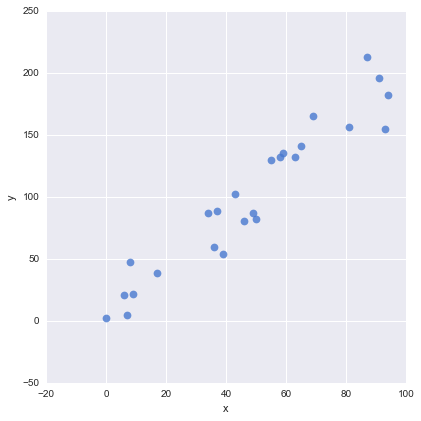

In [10]:
a, b, c, e = 5, 2, 0, 15 
df = generate_data(a=5, b=2, latent_error_y=25)

y = lambda x: a + b*x + c*x**2
x = np.linspace(0, 100)

g = sns.lmplot(x='x', y='y', data=df, fit_reg=False  
               ,size=6, scatter_kws={'alpha':0.8, 's':60})

## NOTE: `lmplot()` will fit and plot a lin. reg. line by default. 
## Not used here, but can greatly help data exploration in practice.

###Fitting an Ordinary Least Square Regression

In [11]:
import patsy as pt  
import statsmodels.api as sm

## first, encode model specification as design matrices
fml = 'y ~ 1 + x'  
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe'
                              ,NA_action='raise')

## fit OLS model and print results
smfit = sm.OLS(endog=mx_en, exog=mx_ex, hasconst=True).fit()  
print(smfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     252.4
Date:                Mon, 18 Apr 2016   Prob (F-statistic):           6.84e-14
Time:                        23:48:23   Log-Likelihood:                -106.47
No. Observations:                  25   AIC:                             216.9
Df Residuals:                      23   BIC:                             219.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      5.4283      6.982      0.778      0.4

###Vizualizing

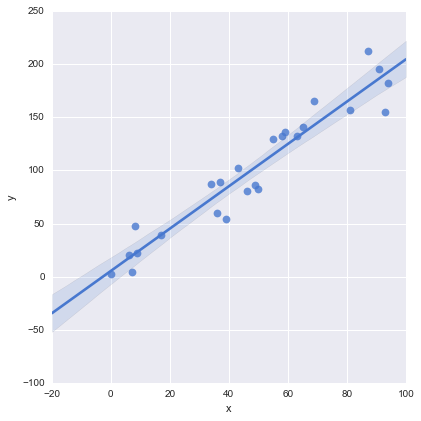

In [12]:
sns.lmplot(x='x', y='y', data=df, fit_reg=True,size=6, scatter_kws={'alpha':0.8, 's':60})

#Generalized Linear Model using PyMC

The Maximum A Posteriori (MAP) was found using Powell Optimization which is basically 
>*An efficient method for finding the minimum of a function of several variables without calculating derivatives*

$$f = \frac{1}{1+(x-y)^2}+ \sin(\frac12 \pi yz) + \exp(-(\frac{x+z}{y}-2)^2)$$

Uses NUTS (No U Turn Sampling) for sampling 
>*a self-tuning variant of Hamiltonian Monte Carlo*

In [5]:
import pymc3 as pm  
from scipy.optimize import fmin_powell

with pm.Model() as mdl_ols:

    ## Use GLM submodule for simplified patsy-like model spec
    ## Use Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.glm('y ~ 1 + x', df, family=pm.glm.families.Normal())

    ## find MAP using Powell optimization
    start_MAP = pm.find_MAP(fmin=fmin_powell)

    ## take samples using NUTS
    trc_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS())

NameError: name 'df' is not defined

###Vizualizing

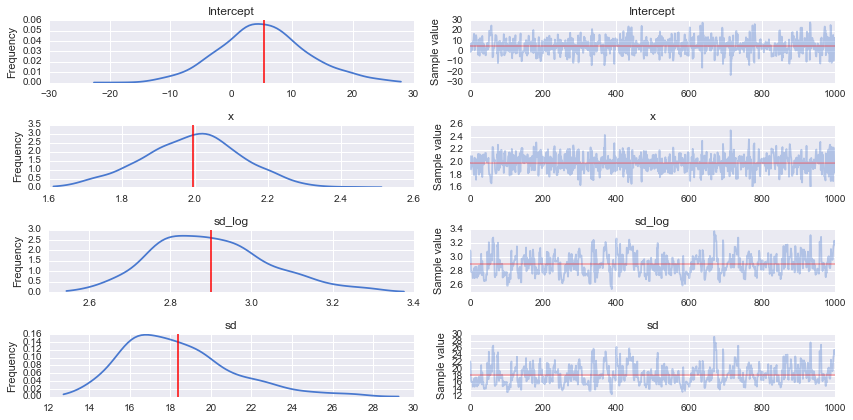

In [14]:
pm.traceplot(trc_ols[-1000:], figsize=(12,len(trc_ols.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trc_ols[-1000:]).iterrows()});

###Summary

In [15]:
pm.df_summary(trc_ols[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,5.352568,7.385067,0.323235,-8.706918,20.720024
x,1.994876,0.135335,0.005654,1.718031,2.237977
sd_log,2.899772,0.142932,0.009561,2.639902,3.194028
sd,18.360603,2.721993,0.180096,13.374517,23.633600


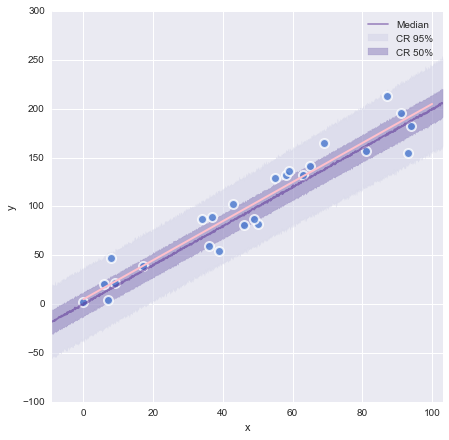

In [16]:
import matplotlib.pyplot as plt

def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['Intercept','x']]
    trc_sd = pm.trace_to_dataframe(trc)['sd']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (df['x'].min() - np.ptp(df['x'])/10, df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_cr(mdl_ols, trc_ols, df, xlims)
plt.plot(x, y(x), color='pink', linestyle='-', linewidth=2)

#Student T-distribution

In [17]:
import pymc3 as pm  
from scipy.optimize import fmin_powell

with pm.Model() as mdl_ols:

    ## Use GLM submodule for simplified patsy-like model spec
    ## Use Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.glm('y ~ 1 + x', df, family=pm.glm.families.StudentT())

    ## find MAP using Powell optimization
    start_MAP = pm.find_MAP(fmin=fmin_powell)

    ## take samples using NUTS
    trc_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS())

Applied log-transform to lam and added transformed lam_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.2 sec

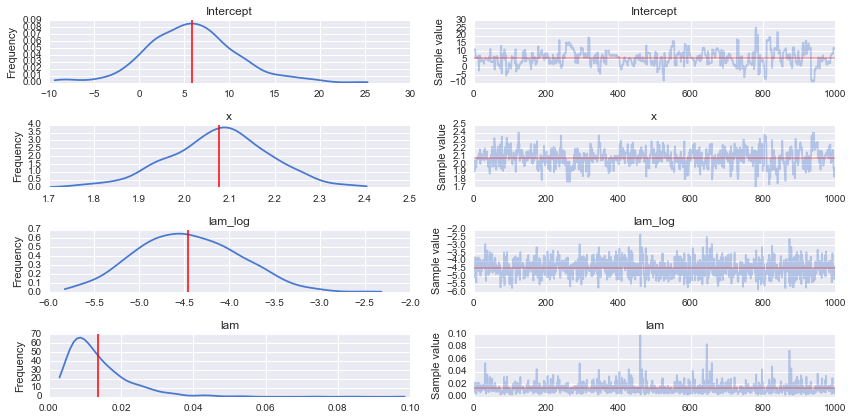

In [20]:
pm.traceplot(trc_ols[-1000:], figsize=(12,len(trc_ols.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trc_ols[-1000:]).iterrows()});

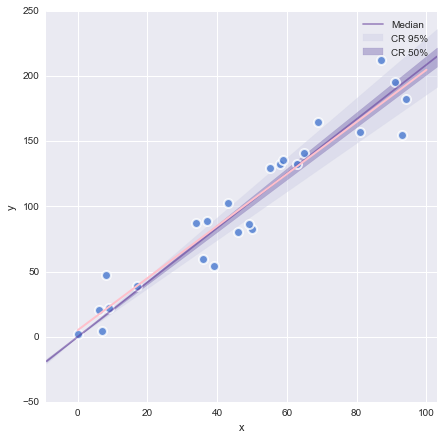

In [21]:
import matplotlib.pyplot as plt

def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['Intercept','x']]
    trc_sd = pm.trace_to_dataframe(trc)['lam']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (df['x'].min() - np.ptp(df['x'])/10, df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_cr(mdl_ols, trc_ols, df, xlims)
plt.plot(x, y(x), color='pink', linestyle='-', linewidth=2)

#Bayesian Linear Regression

In [22]:
trace = None
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    
    y_est = alpha + beta * df['x']
    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=df['y'])
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start, progressbar=False)

Applied interval-transform to sigma and added transformed sigma_interval to model.


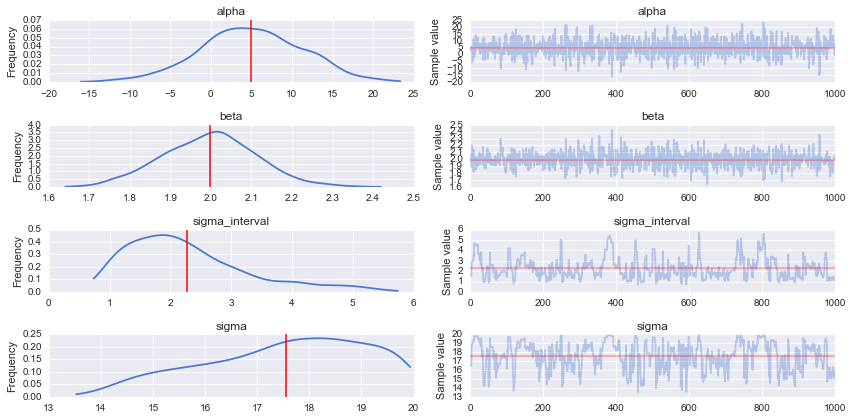

In [23]:
pm.traceplot(trace[-1000:], figsize=(12,len(trace.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trace[-1000:]).iterrows()});

In [24]:
pm.df_summary(trace[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,4.991286,6.376484,0.219470,-7.922216,16.785017
beta,1.997105,0.115964,0.004019,1.757217,2.204160
sigma_interval,2.273023,1.010517,0.082298,0.873568,4.583351
sigma,17.550131,1.553096,0.113487,14.732043,19.936038


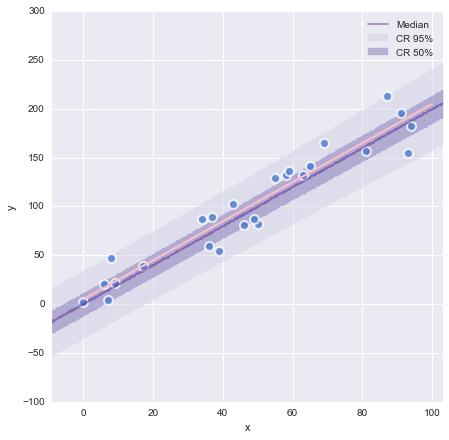

In [25]:
import matplotlib.pyplot as plt

def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['alpha','beta']]
    trc_sd = pm.trace_to_dataframe(trc)['sigma']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (df['x'].min() - np.ptp(df['x'])/10, df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_cr(model, trace, df, xlims)
plt.plot(x, y(x), color='pink', linestyle='-', linewidth=2)

#Quadratic Regression

In [26]:
trace = None
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    mewmew = pm.Normal('mewmew', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    
    y_est = alpha + beta * df['x'] + mewmew * df['x'] * df['x']
    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=df['y'])
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start, progressbar=False)

Applied interval-transform to sigma and added transformed sigma_interval to model.


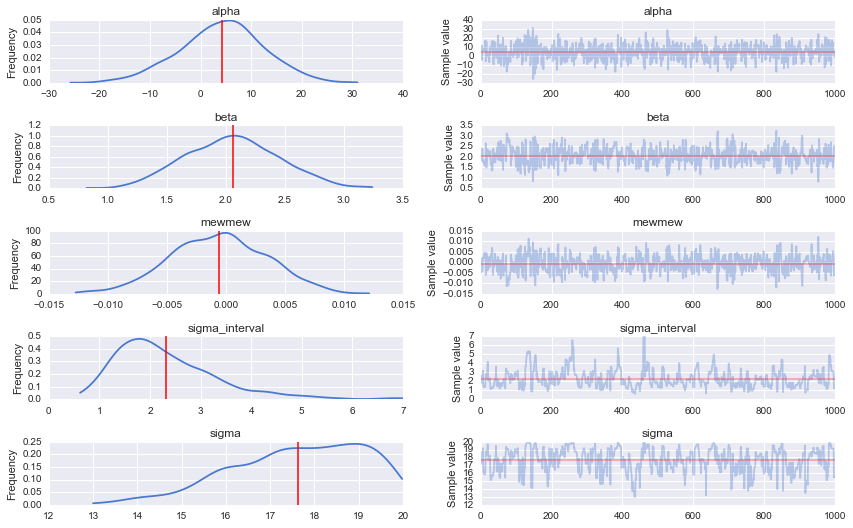

In [27]:
pm.traceplot(trace[-1000:], figsize=(12,len(trace.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trace[-1000:]).iterrows()});

In [28]:
pm.df_summary(trace[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,4.220603,8.303600,0.300042,-11.643565,21.165796
beta,2.058334,0.394903,0.016610,1.325344,2.820633
mewmew,-0.000615,0.004057,0.000173,-0.008676,0.007100
sigma_interval,2.309091,1.016992,0.076233,0.784455,4.369590
sigma,17.634666,1.499546,0.102694,14.988467,19.981618


In [29]:
import matplotlib.pyplot as plt
import numpy as np 
def graph(formula, x_range, color='black', alpha=1):  
    x = np.array(x_range)  
    y = eval(formula)
    plt.plot(x, y, color=color, alpha=alpha)

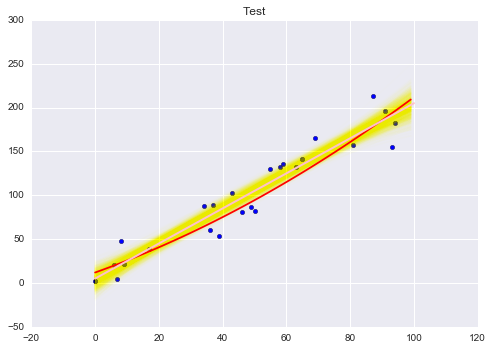

In [30]:
plt.scatter(df['x'],df['y'])

for i in range(0,2000):
    point = trace.point(i)
    graph('{0} + {1}*x + {2}*x*x'.format(point['alpha'], point['beta'], point['mewmew']), range(0,100), color='yellow', alpha=.00908035)

graph('11.9 + 1.3*x + .007*x*x', range(0,100), color='red', alpha=1)
plt.plot(x, y(x), color='pink', linestyle='-', linewidth=2)
plt.title('Test')
plt.show()


#Missing Value Imputation

In [31]:
dia_df = pd.DataFrame.from_csv('diabetes.csv', index_col=False)
dia_df

,id,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn
0,1000,203.0,82,56.0,3.6,4.310000,Buckingham,46,female,62.0,121.0,medium,118.0,59.0,NaN,NaN,29.0,38.0,720.0
1,1001,165.0,97,24.0,6.9,4.440000,Buckingham,29,female,64.0,218.0,large,112.0,68.0,NaN,NaN,46.0,48.0,360.0
2,1002,228.0,92,37.0,6.2,4.640000,Buckingham,58,female,61.0,256.0,large,190.0,92.0,185.0,92.0,49.0,57.0,180.0
3,1003,78.0,93,12.0,6.5,4.630000,Buckingham,67,male,67.0,119.0,large,110.0,50.0,NaN,NaN,33.0,38.0,480.0
4,1005,249.0,90,28.0,8.9,7.720000,Buckingham,64,male,68.0,183.0,medium,138.0,80.0,NaN,NaN,44.0,41.0,300.0
5,1008,248.0,94,69.0,3.6,4.810000,Buckingham,34,male,71.0,190.0,large,132.0,86.0,NaN,NaN,36.0,42.0,195.0
6,1011,195.0,92,41.0,4.8,4.840000,Buckingham,30,male,69.0,191.0,medium,161.0,112.0,161.0,112.0,46.0,49.0,720.0
7,1015,227.0,75,44.0,5.2,3.940000,Buckingham,37,male,59.0,170.0,medium,NaN,NaN,NaN,NaN,34.0,39.0,1020.0
8,1016,177.0,87,49.0,3.6,4.840000,Buckingham,45,male,69.0,166.0,large,160.0,80.0,128.0,86.0,34.0,40.0,300.0
9,1022,263.0,89,40.0,6.6,5.780000,Buckingham,55,female,63.0,202.0,small,108.0,72.0,NaN,NaN,45.0,50.0,240.0


#Fitting Diabetes Data

In [13]:
dia_df = pd.DataFrame.from_csv('diabetes.csv', index_col=False)
dia_df = dia_df.dropna()
col_array = [u'chol', 'stab.glu', u'hdl', u'ratio',
             u'age' , u'height', u'weight', u'bp.1s', u'bp.1d', 
             u'waist', u'hip', u'time.ppn']


In [15]:
trace = None
with pm.Model() as model:
    alpha = pm.Normal('alpha' + str(i), mu=0, sd=20, shape = len(col_array)+1)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    
    
    arr = [alpha[i+1]* dia_df[col_array[i]] for i in range(len(col_array))]
    
    y_est = alpha[0] + np.sum(arr)
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=dia_df['glyhb'])
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start, progressbar=False)

INFO (theano.gof.compilelock): Refreshing lock /Users/Nandita/.theano/compiledir_Darwin-15.4.0-x86_64-i386-64bit-i386-2.7.11-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/Nandita/.theano/compiledir_Darwin-15.4.0-x86_64-i386-64bit-i386-2.7.11-64/lock_dir/lock


Applied interval-transform to sigma and added transformed sigma_interval to model.


In [36]:
pm.df_summary(trace[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha0,-1.257561,3.682711,0.264950,-9.026452,5.764831
alpha1,0.005036,0.005657,0.000198,-0.005592,0.015778
alpha2,0.029961,0.002264,0.000066,0.025582,0.034380
alpha3,0.008227,0.015035,0.000528,-0.019819,0.038768
alpha4,0.199226,0.158125,0.005387,-0.098516,0.497522
alpha5,0.021833,0.010623,0.000353,0.002430,0.042341
alpha6,-0.007619,0.042465,0.002852,-0.086589,0.081683
alpha7,0.008282,0.007898,0.000454,-0.007174,0.023549
alpha8,0.000601,0.007113,0.000211,-0.013898,0.014300
alpha9,-0.000130,0.012301,0.000407,-0.026454,0.022795


#Imputation

In [34]:
trc = None
from pymc3 import *
import numpy as np
import pandas as pd
from numpy.ma import masked_values

# Import data, filling missing values with sentinels (-999)
test_scores = pd.read_csv('test_scores.csv').fillna(-999)

# Extract variables: test score, gender, number of siblings, previous disability, age, 
# mother with HS education or better, hearing loss identified by 3 months of age
(score, male, siblings, disability, 
    age, mother_hs, early_ident) = test_scores[['score', 'male', 'siblings', 
                                                'prev_disab', 'age_test',
                                                'mother_hs', 'early_ident']].astype(float).values.T

with Model() as model:

    # Impute missing values
    sib_mean = Exponential('sib_mean', 1)
    siblings_imp = Poisson('siblings_imp', sib_mean, observed=masked_values(siblings, value=-999))

    p_disab = Beta('p_disab', 1, 1)
    disability_imp = Bernoulli('disability_imp', p_disab, observed=masked_values(disability, value=-999))

    p_mother = Beta('p_mother', 1, 1)
    mother_imp = Bernoulli('mother_imp', p_mother, observed=masked_values(mother_hs, value=-999))

    s = HalfCauchy('s', 5, testval=5)
    beta = Laplace('beta', 0, 100, shape=7, testval=.1)

    expected_score = (beta[0] + beta[1]*male + beta[2]*siblings_imp + beta[3]*disability_imp + 
        beta[4]*age + beta[5]*mother_imp + beta[6]*early_ident)

    observed_score = Normal('observed_score', expected_score, s ** -2, observed=score)


with model:
    start = find_MAP()
    step1 = NUTS([beta, s, p_disab, p_mother, sib_mean], scaling=start)

    step2 = Metropolis([mother_imp.missing_values, 
                        disability_imp.missing_values,
                        siblings_imp.missing_values])

def run(n=5000):
    if n == 'short':
        n = 100
    with model:
        global trc
        trc = sample(n, [step1, step2], start)

if __name__ == '__main__':
    run()
    

Applied log-transform to sib_mean and added transformed sib_mean_log to model.
Applied logodds-transform to p_disab and added transformed p_disab_logodds to model.
Applied logodds-transform to p_mother and added transformed p_mother_logodds to model.
Applied log-transform to s and added transformed s_log to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 28.5 sec

In [37]:
pm.summary(trc)


sib_mean_log:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.115            0.068            0.001            [-0.019, 0.246]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.022         0.070          0.117          0.160          0.245


siblings_imp_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|


p_disab_logodds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -1.273           0.168            0.002            [-1.615, -